In [1]:
import mapsims
import numpy as np
import healpy as hp
import pysm3.units as u
from pathlib import Path
import toml
%matplotlib inline
import matplotlib.pyplot as plt

# Run map-based simulations on-the-fly starting from configuration files

Once the Map-Based-Simulations group publishes a simulation release, it will provide configuration files which setup `mapsims` with all the correct parameters,
see for example the 2 configuration toml (like `.ini` files <https://github.com/toml-lang/toml>) files: 

In [2]:
!git clone --depth 1 https://github.com/simonsobs/map_based_simulations.git

fatal: destination path 'map_based_simulations' already exists and is not an empty directory.


In [3]:
!ls map_based_simulations/202006_noise/*.toml

map_based_simulations/202006_noise/common.toml
map_based_simulations/202006_noise/noise.toml


Multiple configuration files can be fed to `mapsims`, the `common.toml` generally contains general information about the output path, naming, units, simulation seed and splits.

The `num` parameter is very important because it is passed thorugh to all the other simulation classes. So if you change that to 1, all the components a that support a seed, for example also CMB, creates a new realization which is reproducible.

In [4]:
!cat map_based_simulations/202006_noise/common.toml

output_folder = "output/{tag}/{num:04d}"
output_filename_template="simonsobs_{tag}_uKCMB_{telescope}_{band}_nside{nside}_{num:04d}_{split}_of_{nsplits}.fits"
channels = "tube:ST3"
unit = "uK_CMB"
mapsims_version = "2.3.0"
so_pysm_models_version = "2.3.0"
num = 0
nsplits = 1
instrument_parameters = "simonsobs_instrument_parameters_2020.06"


The TOML files for each component are very general, they get a `class` attribute and then every other attribute is just passed to the class constructor, therefore it can execute any class as long as it has a standard `simulate` method with the expected signature.

I also have a command line tool that can directly produce simulations from configuration files, `mapsims_run`, which I use to produce the map-based simulation releases. But we can also use those configuration files as a starting point for custom runs using the Python classes.

In [5]:
!cat map_based_simulations/202006_noise/noise.toml


tag = "noise"

[ other_components ]

    [ other_components.noise ]

    class = "mapsims.SONoiseSimulator"
    return_uK_CMB = true
    sensitivity_mode = "baseline"
    apply_beam_correction = false
    apply_kludge_correction = true
    homogeneous = false
    rolloff_ell = 50
    survey_efficiency = 0.2
    full_covariance = true
    LA_years = 5
    LA_noise_model = "SOLatV3point1"
    elevation = 50
    SA_years = 5
    SA_one_over_f_mode = "pessimistic"
    cache_hitmaps = true
    boolean_sky_fraction = false


The simplest way is to just copy-paste this configuration directly into a class constructor or load it with TOML, which creates a dictionary from a `.toml` file.

In [6]:
noise_config = toml.load("map_based_simulations/202006_noise/noise.toml")["other_components"]["noise"]

In [7]:
noise_config

{'class': 'mapsims.SONoiseSimulator',
 'return_uK_CMB': True,
 'sensitivity_mode': 'baseline',
 'apply_beam_correction': False,
 'apply_kludge_correction': True,
 'homogeneous': False,
 'rolloff_ell': 50,
 'survey_efficiency': 0.2,
 'full_covariance': True,
 'LA_years': 5,
 'LA_noise_model': 'SOLatV3point1',
 'elevation': 50,
 'SA_years': 5,
 'SA_one_over_f_mode': 'pessimistic',
 'cache_hitmaps': True,
 'boolean_sky_fraction': False}

In [8]:
noise_config.pop("class")

'mapsims.SONoiseSimulator'

In [9]:
noise_sim = mapsims.SONoiseSimulator(nside=128, **noise_config)

# Use the map simulator class MapSim

We load the configuration files and then we override whatever configuration option we need,
or we could create another TOML file and load it after `noise.toml`.
`num` is the realization number, i.e. it fixes the seed for all different channels,
the set of maps released were generated with `num=0`, we can set it to 1 to get a different set.

We always work 1 tube at a time and get 2 maps with a cross-correlated component given by the atmosphere:

In [10]:
sim = mapsims.from_config(["map_based_simulations/202006_noise/common.toml",
                           "map_based_simulations/202006_noise/noise.toml"],
                           override={"channels":"tube:ST3", "output_folder":".", "num":1})

In [11]:
type(sim)

mapsims.runner.MapSim

Finally call execute to generate and return the maps.

NSIDE is automatically set based on the channel, you can also override that by providing `nside` key to `override`.

In [12]:
noise = sim.other_components["noise"]

In [13]:
maps_1 = sim.execute()

/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/healpix/ST3_LF1_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz
  warnings.warn(f"Access data from {full_path}")
/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/healpix/ST3_LF2_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz
  warnings.warn(f"Access data from {full_path}")
/global/common/software/sobs/mbs/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


In [14]:
maps_1.keys()

dict_keys(['ST3_LF1', 'ST3_LF2'])

In [15]:
maps_1["ST3_LF1"].shape

(3, 196608)

To get another realization you can either create another `sim` object with a different `num`
or directly override it on a already existing object:

In [16]:
sim.num = 2 # this is only used for the output filename
sim.other_components["noise"].seed = 2 # this is the actual realization number
maps_2 = sim.execute()

To change tube without creating another `sim` object, override `sim.channels`:

In [17]:
sim.channels

[(Channel ST3_LF1, Channel ST3_LF2)]

In [18]:
sim.channels = mapsims.parse_channels("tube:ST0")

In [19]:
sim.execute().keys()

/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/healpix/ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz
  warnings.warn(f"Access data from {full_path}")
/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/healpix/ST0_UHF2_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz
  warnings.warn(f"Access data from {full_path}")


dict_keys(['ST0_UHF1', 'ST0_UHF2'])

## Write output maps

In [20]:
# save fits files instead
sim.execute(write_outputs=True)

/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/runner.py:396: UserWarning: Writing output map simonsobs_noise_uKCMB_ST0_UHF1_nside128_0002_1_of_1.fits
  warnings.warn("Writing output map " + filename)
/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/runner.py:396: UserWarning: Writing output map simonsobs_noise_uKCMB_ST0_UHF2_nside128_0002_1_of_1.fits
  warnings.warn("Writing output map " + filename)


In [21]:
%ls *.fits

simonsobs_noise_uKCMB_ST0_UHF1_nside128_0002_1_of_1.fits
simonsobs_noise_uKCMB_ST0_UHF2_nside128_0002_1_of_1.fits


## Plot the output maps

In [22]:
import healpy as hp

In [23]:
%matplotlib inline

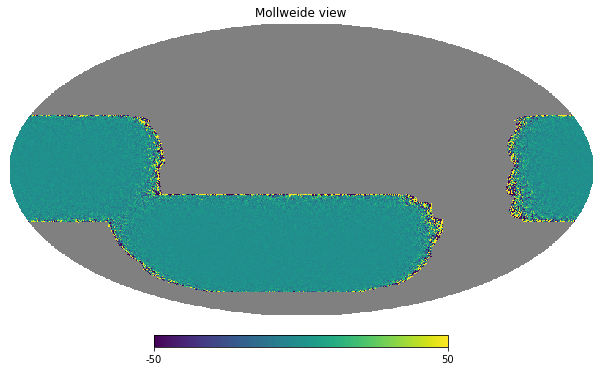

In [24]:
hp.mollview(maps_1["ST3_LF1"][1], min=-50, max=50)

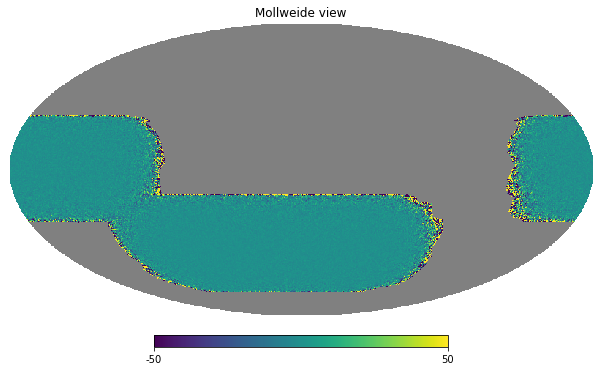

In [25]:
hp.mollview(hp.ma(maps_2["ST3_LF1"][1]), min=-50, max=50)

# Generate multiple splits

Override `nsplits` to generate multiple splits, the output maps will be a 3 dimensional array where for each split we have the 3 IQU components.

In [26]:
sim = mapsims.from_config(["map_based_simulations/202006_noise/common.toml",
                           "map_based_simulations/202006_noise/noise.toml"],
                          override={"channels":"tube:ST3", "output_folder":".", "num":1, "nsplits":4})

In [27]:
maps = sim.execute()

In [28]:
maps["ST3_LF1"].shape

(4, 3, 196608)

# Generate noise and CMB

We can also check other map-based simulations releases and combine different configuration files to produce on-the-fly maps which have multiple components, for example noise and CMB.

The `201911_lensed_cmb` includes 100 lensed CMB realizations, we can grab the `cmb.toml` file used to generate them, customize it with the correct path for NERSC, and feed it into `mapsims.from_config`.

In [29]:
!ls map_based_simulations/201911_lensed_cmb

README.md  cmb.toml  common.toml  submit.slurm	submit_4096.slurm  test.sh


In [30]:
!cat map_based_simulations/201911_lensed_cmb/cmb.toml


tag = "cmb"

[ other_components ]

    [ other_components.cmb ]
    class  =  "mapsims.SOStandalonePrecomputedCMB"
    lensed = true
    # num is then overridden by command line option to mapsims_run
    num = 0
    aberrated = false
    has_polarization = true
    cmb_set = 0
    # At NERSC use:
    # cmb_dir = "/global/project/projectdirs/sobs/v4_sims/mbs/cmb"
    # On Popeye use:
    cmb_dir = "/simons/scratch/zonca/simonsobs/lensed_cmb"
    input_units = "uK_CMB"


In [31]:
%%file cmb.toml

tag = "cmb"

[ other_components ]

    [ other_components.cmb ]
    class  =  "mapsims.SOStandalonePrecomputedCMB"
    lensed = true
    # num is then overridden by command line option to mapsims_run
    num = 0
    aberrated = false
    has_polarization = true
    cmb_set = 0
    # At NERSC use:
    cmb_dir = "/global/project/projectdirs/sobs/v4_sims/mbs/cmb"
    # On Popeye use:
    # cmb_dir = "/simons/scratch/zonca/simonsobs/lensed_cmb"
    input_units = "uK_CMB"

Writing cmb.toml


In [32]:
sim_noise_cmb = mapsims.from_config(["map_based_simulations/202006_noise/common.toml",
                           "map_based_simulations/202006_noise/noise.toml",
                           "cmb.toml"],
                          override={"channels":"tube:ST3", "output_folder":".", "num":1, "nsplits":1})

In [33]:
sim_noise_cmb.other_components

{'noise': <mapsims.noise.SONoiseSimulator at 0x2aaaeae9edd0>,
 'cmb': <mapsims.cmb.SOStandalonePrecomputedCMB at 0x2aaae57fa7d0>}

In [34]:
maps_noise_cmb = sim_noise_cmb.execute()

Sigma is 61.151170 arcmin (0.017788 rad) 
-> fwhm is 144.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 42.041429 arcmin (0.012229 rad) 
-> fwhm is 99.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


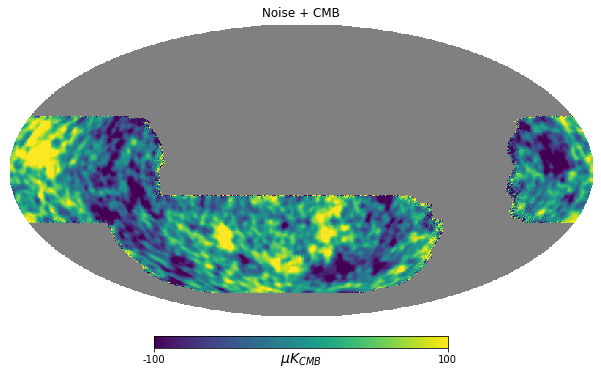

In [35]:
hp.mollview(hp.ma(maps_noise_cmb["ST3_LF1"][0]), title="Noise + CMB", unit="$\mu K_{CMB}$", min=-100, max=100)

# Add foreground components

We can also look at the older release `201906_highres_foregrounds_extragalactic_tophat` we saw in notebook 1, but now, instead of reading maps from disk, we generate it on the fly, which is convenient if we want a different $N_{side}$.
Also, depending on the specific case, it might be quicker to generate components on-the-fly instead of loading multiple maps from disk./ 

In [36]:
!ls map_based_simulations/201906_highres_foregrounds_extragalactic_tophat/

README.md			      dust_512.toml
ame_4096.toml			      execute.sh
ame_512.toml			      freefree_4096.toml
cib.toml			      freefree_512.toml
cmb.toml			      ksz.toml
cmb_lensed_solardipole.toml	      prepare_slurm_scripts_by_freq.py
cmb_unlensed.toml		      submit.slurm
combine_maps.py			      submit_nside.slurm
common.toml			      synchrotron_4096.toml
create_map_from_alm.ipynb	      synchrotron_512.toml
create_map_from_alm_add_dipole.ipynb  tsz.toml
dust_4096.toml


In [37]:
!cat map_based_simulations/201906_highres_foregrounds_extragalactic_tophat/synchrotron_512.toml

tag = "synchrotron"

[pysm_components]
pysm_components_string = "SO_s0"
pysm_output_reference_frame = "C"


In [38]:
sim_noise_cmb_sync = mapsims.from_config(["map_based_simulations/202006_noise/common.toml",
                           "map_based_simulations/202006_noise/noise.toml",
                           "cmb.toml",
                           "map_based_simulations/201906_highres_foregrounds_extragalactic_tophat/synchrotron_512.toml"
                          ],
                          override={"channels":"tube:ST3", "output_folder":".", "num":1, "nsplits":1})

In [39]:
maps_noise_cmb_sync = sim_noise_cmb_sync.execute()

/global/common/software/sobs/mbs/lib/python3.7/site-packages/so_pysm_models/utils/__init__.py:50: UserWarning: Access data from /global/project/projectdirs/cmb/www/so_pysm_models_data/equatorial/synch_T_ns512.fits
  warnings.warn(f"Access data from {full_path}")
/global/common/software/sobs/mbs/lib/python3.7/site-packages/so_pysm_models/utils/__init__.py:50: UserWarning: Access data from /global/project/projectdirs/cmb/www/so_pysm_models_data/equatorial/synch_Q_ns512.fits
  warnings.warn(f"Access data from {full_path}")
/global/common/software/sobs/mbs/lib/python3.7/site-packages/so_pysm_models/utils/__init__.py:50: UserWarning: Access data from /global/project/projectdirs/cmb/www/so_pysm_models_data/equatorial/synch_U_ns512.fits
  warnings.warn(f"Access data from {full_path}")
/global/common/software/sobs/mbs/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /global/project/projectdirs/cmb/www/so_pysm_models_data/equatorial/synch_T_ns512.fits
  warnings

Sigma is 61.151170 arcmin (0.017788 rad) 
-> fwhm is 144.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 42.041429 arcmin (0.012229 rad) 
-> fwhm is 99.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


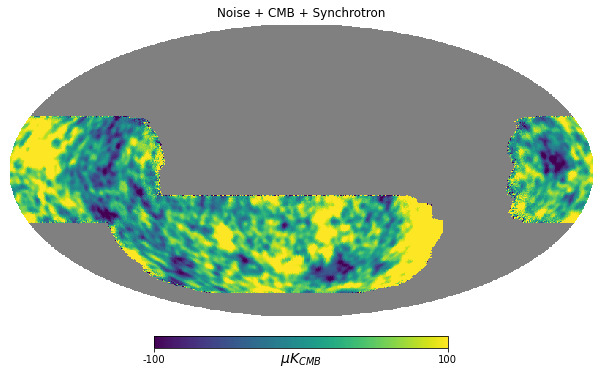

In [40]:
hp.mollview(hp.ma(maps_noise_cmb_sync["ST3_LF1"][0]), title="Noise + CMB + Synchrotron", unit="$\mu K_{CMB}$", min=-100, max=100)